In [1]:
# import tensorflow
import tensorflow as tf

# notebook that uses CNNs for text spam detection

this notebook follows the text preproccessing notebook!

In [6]:
# other imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

text loading is the same as in the spam detection RNN notebook, so look there for more details

In [3]:
# get data (url doesn't work directly with pd.read_csv)
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2023-05-11 23:49:10--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  1.30MB/s    in 0.4s    

2023-05-11 23:49:11 (1.30 MB/s) - ‘spam.csv’ saved [503663/503663]



In [8]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df.columns = ['labels', 'data']

# create binary labels column, where spam = 1 and not spam (ham) = 0
df['b_labels'] = df['labels'].map({'ham':0, 'spam':1})
Y = df['b_labels'].values 

df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [7]:
# split data into training and testing splits
df_train, df_test, Y_train, Y_test = train_test_split(df['data'], Y, test_size=0.3)

In [9]:
# sentences to sequences
max_vocab_size = 20000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [10]:
# now word to integer mapping, see how many unique words (tokens) we have 
word2idx = tokenizer.word_index
v = len(word2idx)
print('found %s unique tokens' % v)

found 7387 unique tokens


In [11]:
# pad train sequences to get an N x T matrix
data_train = pad_sequences(sequences_train)
print('shape of training tensor:', data_train.shape)

# sequence length T
T = data_train.shape[1]

# pad test sequences 
# max length needs to be T to match train, so longer sentences will be truncated
data_test = pad_sequences(sequences_test, maxlen=T)
print('shape of testing tensor:', data_test.shape)

shape of training tensor: (3900, 189)
shape of testing tensor: (1672, 189)


now onto the model: 

In [12]:
# embedding dimensionality (D)
D = 20

# hidden state dimensionality (M)
M = 15

# note: want to use the size of the embedding to (V+1) x D as the first index
# starts at 1 instead of 0 -> zero used for padding!
# therefore if the final index of the emedding matrix is V, it'll really be V+1

# model, using convolution layers following an embedding layer! 
i = Input(shape=(T,))                  
x = Embedding(v+1, D)(i)               
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = GlobalMaxPooling1D()(x)           
x = Dense(1, activation='sigmoid')(x)  

model = Model(i, x)

In [13]:
# compile & fit
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

r = model.fit(data_train, Y_train, 
              epochs=5,
              validation_data=(data_test, Y_test))

Epoch 1/5
122/122 [==============================] - 5s 24ms/step - loss: 0.3925 - accuracy: 0.8628 - val_loss: 0.2822 - val_accuracy: 0.8612
Epoch 2/5
122/122 [==============================] - 4s 33ms/step - loss: 0.1396 - accuracy: 0.9400 - val_loss: 0.0600 - val_accuracy: 0.9850
Epoch 3/5
122/122 [==============================] - 3s 22ms/step - loss: 0.0219 - accuracy: 0.9941 - val_loss: 0.0573 - val_accuracy: 0.9874
Epoch 4/5
122/122 [==============================] - 3s 22ms/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.0574 - val_accuracy: 0.9868
Epoch 5/5
122/122 [==============================] - 3s 29ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0618 - val_accuracy: 0.9880


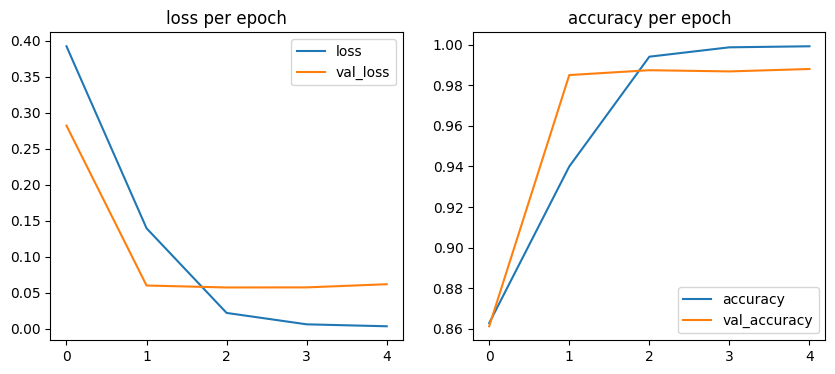

In [14]:
# plot loss and accuracy 
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(r.history['loss'], label='loss')
ax[0].plot(r.history['val_loss'], label='val_loss')
ax[0].legend()
ax[0].set_title('loss per epoch')
ax[1].plot(r.history['accuracy'], label='accuracy')
ax[1].plot(r.history['val_accuracy'], label='val_accuracy')
ax[1].legend()
ax[1].set_title('accuracy per epoch')
plt.show()